In [237]:
import os
import ntpath
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import random
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [238]:
#Exploring data capture from driving 
datadir = 'driving_data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...   

                                                left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   

                                               right  steering  throttle  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   

   reverse     speed  
0      0.0  0.649786  
1      0.0  0.627942  
2      0.0  0.622910  
3      0.0  0.619162  
4      0.0  0.615438

In [239]:
#Start cleaning the collected data removing the path from the images name
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()



center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


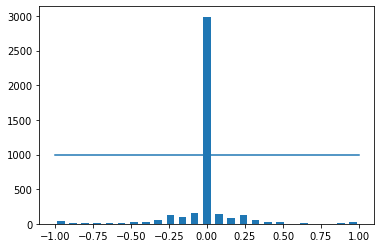

In [241]:
#Exploring data visualizing steering angle distribution
num_bins = 25
samples_per_bin = 1000 # to avoid skewing data to zero angle we are limiting to 1000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5 # Adding the value of 0 to our distribution to have the center value at zero
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 1990
remaining: 2063


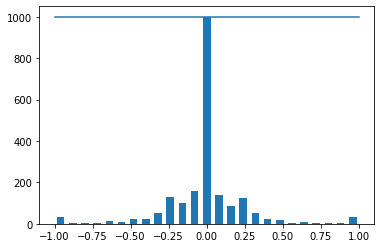

In [242]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
            
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
                    

In [243]:
#Loading data into arrays for easy manipulation and access
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        correction = 0.2 # this is a parameter to tune
        
        #Adding center image
        #if float(indexed_data[3]) != 0:
        #    #Adding left image                
        #    if float(indexed_data[3]) < -0.1:
        #        image_path.append(os.path.join(datadir, right.strip()))
        #        steering.append(abs(float(indexed_data[3])) / 2 )
                
            #Adding right image
        #    if float(indexed_data[3]) > 0.1:
        #        image_path.append(os.path.join(datadir, left.strip()))
        #        steering.append(-(float(indexed_data[3] / 2))                
        #else:
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_43_792.jpg
left          left_2018_07_16_17_11_43_792.jpg
right        right_2018_07_16_17_11_43_792.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                 0.619162
Name: 3, dtype: object


In [244]:
#spliting data into training and validation set 
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1650
Valid Samples: 413


Text(0.5, 1.0, 'Validation set')

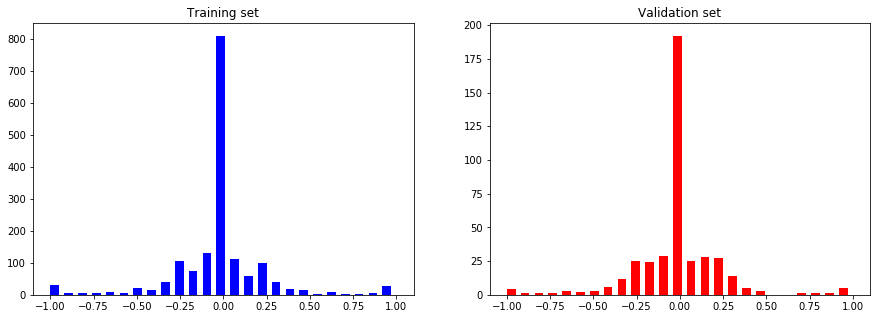

In [245]:
#visualizing datasets
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [246]:
#Data augmentation
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1, 'Zoomed image')

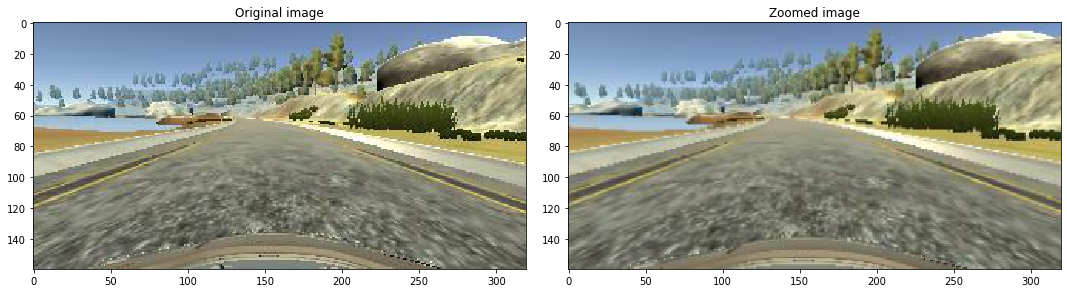

In [247]:
#Testing zooming
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original image")
axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed image")

In [248]:
#Data augmentation
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.2, 0.2), "y":(-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1, 'Panned image')

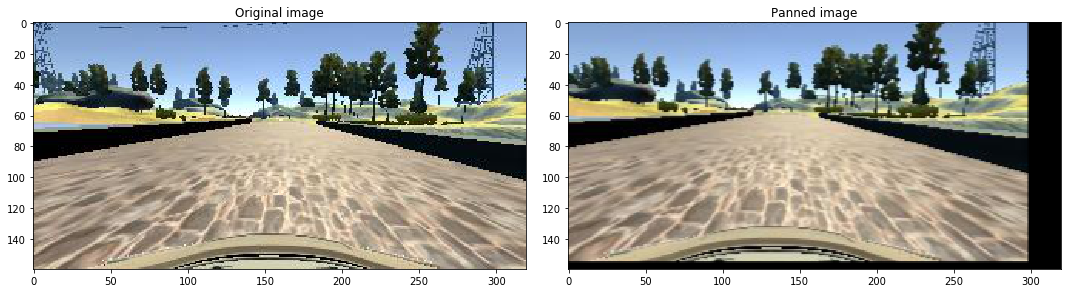

In [249]:
#Testing pan
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original image")
axs[1].imshow(panned_image)
axs[1].set_title("Panned image")

In [250]:
#Data augmentation
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'Brightness altered image')

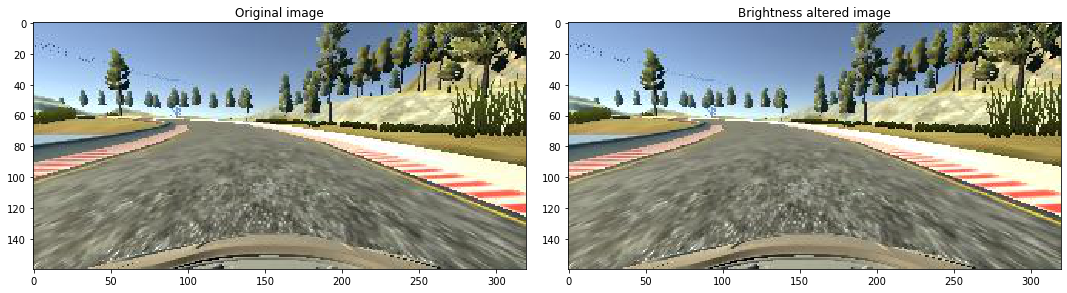

In [251]:
#Testing Brightness
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original image")
axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered image")

In [252]:
#Data augmentation
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle 
    return image, steering_angle

Text(0.5, 1, 'Flipped image | Flipped Steering angle: 0.08172913')

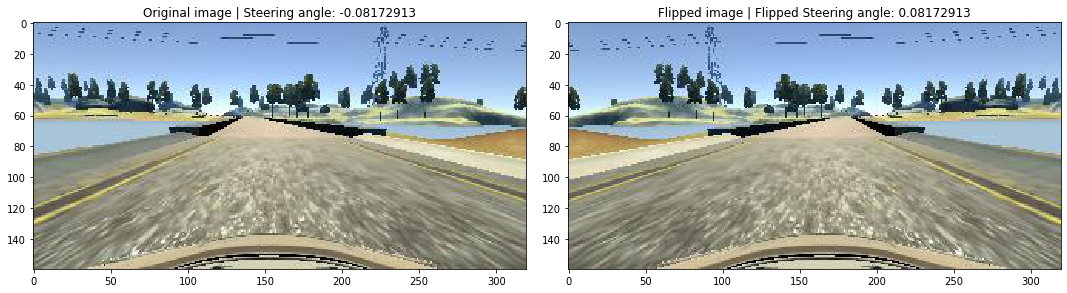

In [253]:
#Testing image flipping
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original image | Steering angle: " + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title("Flipped image | Flipped Steering angle: " + str(flipped_steering_angle))

In [254]:
def img_preprocess(img):
    img = img[60:135,:,:] #Cropping features not necessary in the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #Converting from RGB to YUV Because the NVDIA neural model
    img = cv2.GaussianBlur(img, (3,3), 0) #Smoothing and reducing the noise
    img = cv2.resize(img, (200, 66)) #Resizing the image will help with computation and also match image size for NVDIA model architecture
    img = img / 255 # Normalizing values in the image
    return img

In [255]:
#Applying randomly the data augmentation techniques to an image
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)    
    
    return image, steering_angle

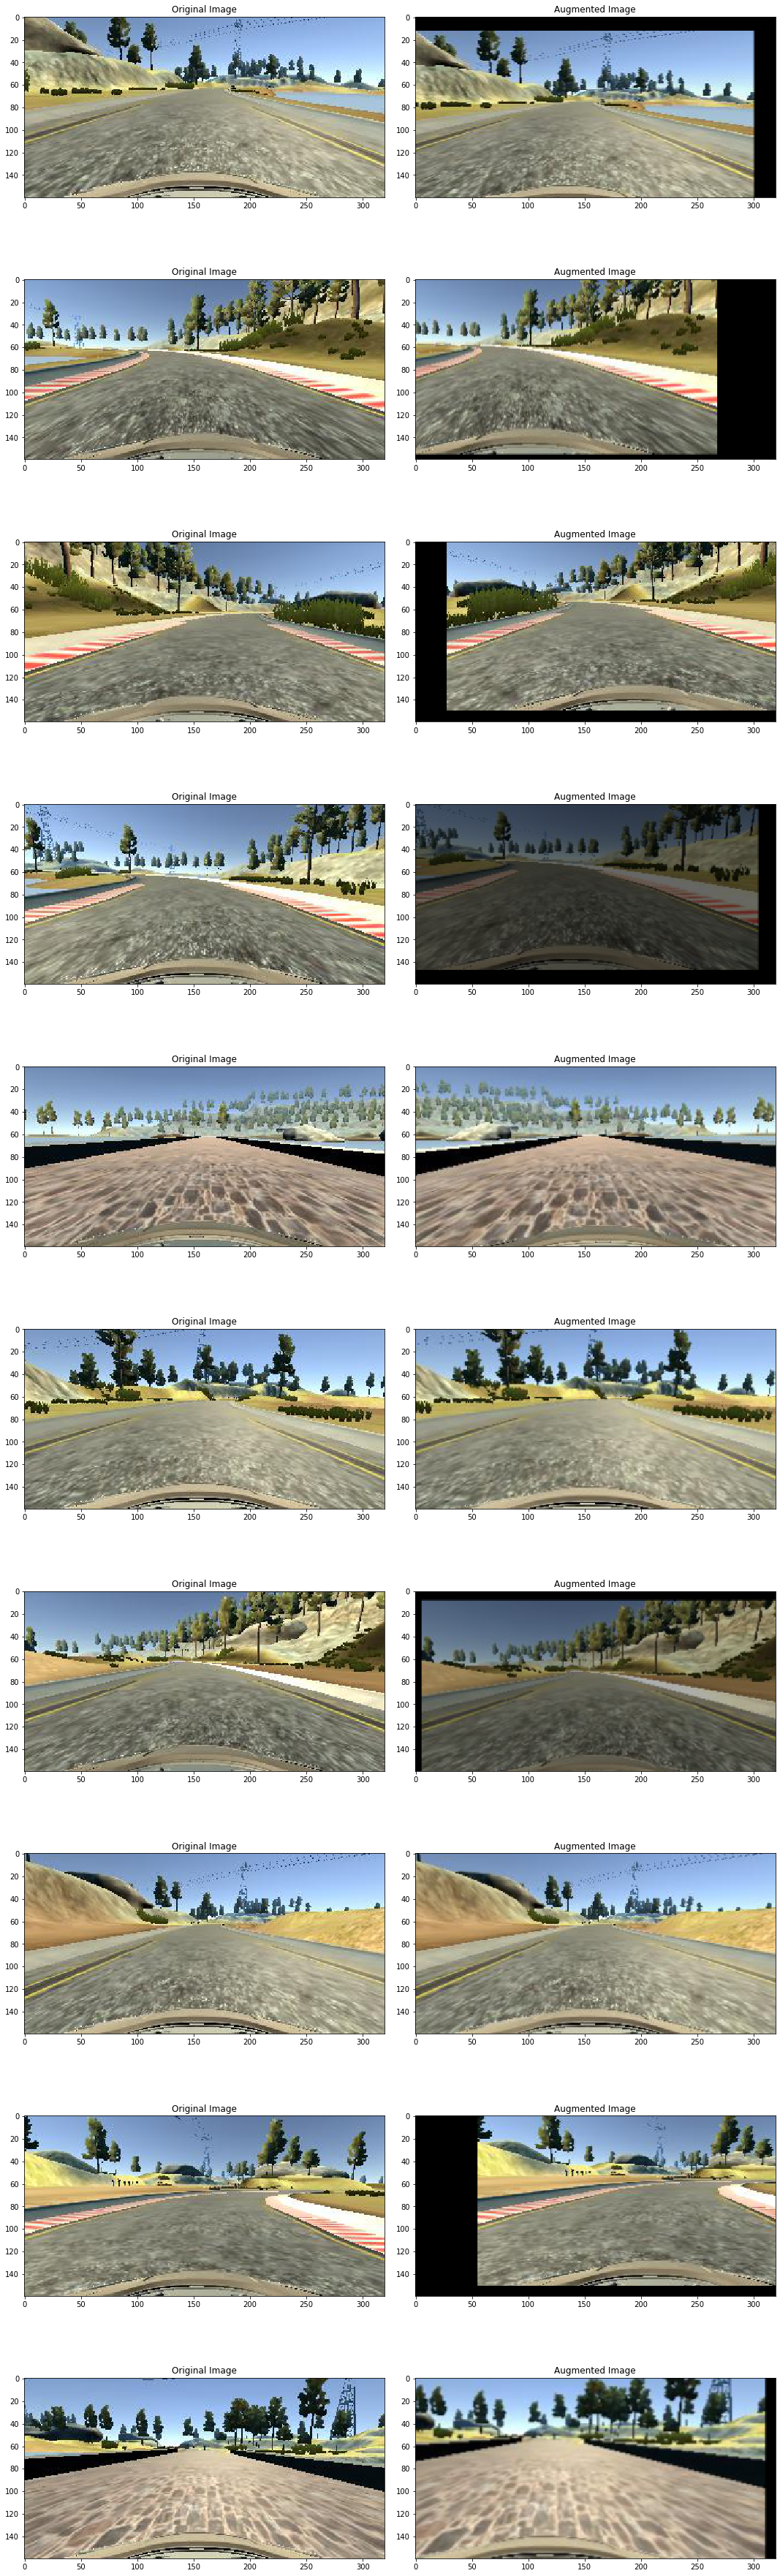

In [256]:
#Generating augmented images randomly
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')
    
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image')

In [257]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1, 'Validation Image')

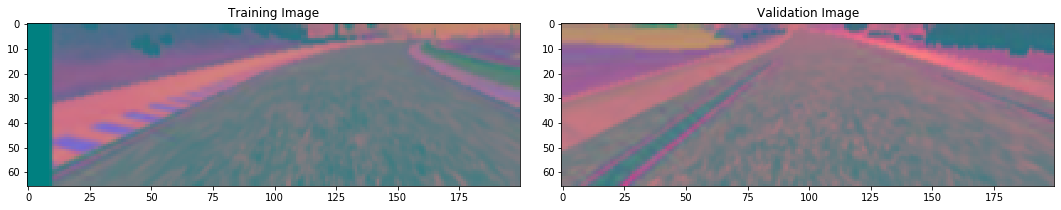

In [258]:
#Testing our augmented batch_generator
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [259]:
def nvidia_model():
     
    model = Sequential()
    
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
     
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
     
     
    optimizer= Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
     
    return model

In [260]:
model = nvidia_model()
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)             

In [261]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 200, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 200, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 385s 1s/step - loss: 0.0611 - val_loss: 0.0502
Epoch 2/10
300/300 [==============================] - 353s 1s/step - loss: 0.0503 - val_loss: 0.0380
Epoch 3/10
300/300 [==============================] - 379s 1s/step - loss: 0.0489 - val_loss: 0.0364
Epoch 4/10
300/300 [==============================] - 363s 1s/step - loss: 0.0448 - val_loss: 0.0331
Epoch 5/10
300/300 [==============================] - 359s 1s/step - loss: 0.0418 - val_loss: 0.0251
Epoch 6/10
300/300 [==============================] - 352s 1s/step - loss: 0.0380 - val_loss: 0.0221
Epoch 7/10
300/300 [==============================] - 353s 1s/step - loss: 0.0360 - val_loss: 0.0348
Epoch 8/10
300/300 [==============================] - 345s 1s/step - loss: 0.0342 - val_loss: 0.0283
Epoch 9/10
300/300 [==============================] - 333s 1s/step - loss: 0.0339 - val_loss: 0.0278
Epoch 10/10
300/300 [==============================] - 318s 1s/step - loss: 0.0317 - val_lo

Text(0.5, 0, 'Epoch')

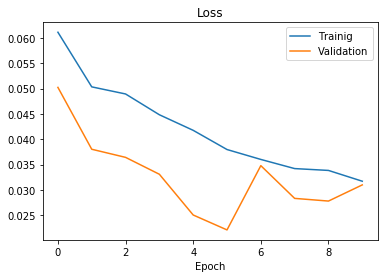

In [264]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Trainig', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [265]:
model.save('model.h5')